In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing.DataLoader import DataLoader
from sklearn.preprocessing import StandardScaler

In [3]:
def unite_sets(deliveries, products, sessions, users):
    deliveries["deltas"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]

    # divide category
    categories = products.category_path.str.split(';', expand=True)
    products = pd.concat([products, categories], axis=1)
    products = products.drop(columns=['category_path'])
    products = products.rename(
        columns={0: "primary_category", 1: "secondary_category", 2: "tertiary_category", 3: "quaternary_category"})


    deliveries_sessions = pd.merge(deliveries, sessions, left_on="purchase_id", right_on="purchase_id")
    deliveries_sessions_users = pd.merge(deliveries_sessions, users, left_on="user_id", right_on="user_id")
    deliveries_sessions_users_products = pd.merge(deliveries_sessions_users, products, left_on="product_id", right_on="product_id")

    deliveries_sessions_users_products.to_csv('../out.csv')
    return deliveries_sessions_users_products

In [4]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [5]:
def one_hot_encode(united, s):
    y = pd.get_dummies(united[s], prefix=s)
    united = united.join(other=y)
    united = united.loc[:, united.columns != s]
    return united

In [6]:
    def oneHotEncode(united, columns):
        for column in columns:
            united = one_hot_encode(united, column)
        return united

In [20]:
d = DataLoader.load_data_from_path("data")

products = d.products
deliveries = d.deliveries
sessions = d.sessions
users = d.users

united = unite_sets(deliveries, products, sessions, users)

# nie wnosi zadnej informacji wiec wyrzucamy daną kolumnę
united = united.loc[:, united.columns != 'event_type']
united = united.loc[:, united.columns != 'name']
united = united.loc[:, united.columns != 'street']
united = united.loc[:, united.columns != 'product_name']
united = united.loc[:, united.columns != 'delivery_timestamp']
united = united.loc[:, united.columns != 'timestamp']
united = united.loc[:, united.columns != 'purchase_id']
united = united.loc[:, united.columns != 'product_id']
united = united.loc[:, united.columns != 'user_id']
united = united.loc[:, united.columns != 'session_id']
united = united.loc[:, united.columns != 'primary_category']
united = united.loc[:, united.columns != 'secondary_category']
united = united.loc[:, united.columns != 'tertiary_category']
united = united.loc[:, united.columns != 'quaternary_category']
# united = united.loc[:, united.columns != 'offered_discount']
# united = united.loc[:, united.columns != 'price']

united.to_csv("test.csv")

united.loc[:,'time_of_day'] = united.apply(lambda row: labelTimeOfDay(row), axis=1)
united['weekday'] = united['purchase_timestamp'].dt.day_name()
united = united.loc[:, united.columns != 'purchase_timestamp']

united = oneHotEncode(united, {'city', 'delivery_company', 'time_of_day', 'weekday'})
# united = one_hot_encode(united, 'city')
# united.to_csv("city.csv")
# united = one_hot_encode(united, 'delivery_company')
# united = one_hot_encode(united, 'time_of_day')
# united = one_hot_encode(united, 'weekday')


united['deltas'] = pd.to_numeric(united['deltas'].dt.days, downcast='integer')


# normalizacja deltas
# unitated['deltas'] = unitated['deltas'] /unitated['deltas'].abs().max()


# train, test = train_test_split(unitated, test_size=0.2)
# X_train = train.loc[:, train.columns != 'deltas']
# y_train = train['deltas']

# X_test = test.loc[:, test.columns != 'deltas']
# y_test = test['deltas']

In [21]:
x = united.drop('deltas', axis=1)
y = united['deltas']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=40)
# #Scaling
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_test.to_csv("notzero.csv")

In [22]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_test

5586    1
1239    1
6197    2
5839    2
4248    1
       ..
4760    0
7180    1
2171    3
305     1
4074    1
Name: deltas, Length: 2248, dtype: int8

In [25]:
y_pred

array([0, 2, 4, ..., 3, 4, 0], dtype=int8)

In [26]:
accuracy = accuracy_score(y_test, y_pred)*100

In [27]:
accuracy

39.05693950177936

In [28]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [29]:
from sklearn.metrics import classification_report,confusion_matrix

#Evaluate predictions for train data
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[ 770   49    4    0    0]
 [1360  809  139   41   77]
 [ 288  409  310  270  210]
 [  41   13   31  234  143]
 [   0    0    0    0   47]]
              precision    recall  f1-score   support

           0       0.31      0.94      0.47       823
           1       0.63      0.33      0.44      2426
           2       0.64      0.21      0.31      1487
           3       0.43      0.51      0.46       462
           4       0.10      1.00      0.18        47

    accuracy                           0.41      5245
   macro avg       0.42      0.60      0.37      5245
weighted avg       0.56      0.41      0.41      5245



In [30]:
#Evaluate predictions for test data
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[309  15   3   0   0]
 [615 335  56  14  34]
 [138 194 130 112  73]
 [ 21   5  16  84  71]
 [  0   0   0   3  20]]
              precision    recall  f1-score   support

           0       0.29      0.94      0.44       327
           1       0.61      0.32      0.42      1054
           2       0.63      0.20      0.31       647
           3       0.39      0.43      0.41       197
           4       0.10      0.87      0.18        23

    accuracy                           0.39      2248
   macro avg       0.41      0.55      0.35      2248
weighted avg       0.55      0.39      0.39      2248



<function matplotlib.pyplot.show(close=None, block=None)>

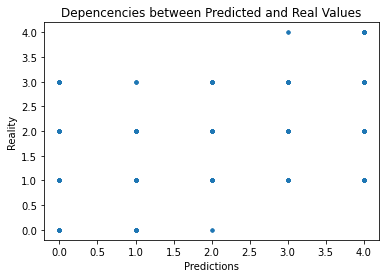

In [32]:
plt.plot(y_pred, y_test,".")
plt.title("Depencencies between Predicted and Real Values")
plt.xlabel("Predictions")
plt.ylabel("Reality")
plt.show

In [33]:
import pickle
f = open('models/bayes_1.0.0.pickle', 'wb')
pickle.dump(model, f)
f.close()